In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the data
df = pd.read_csv('NUene_database_data.csv', sep=';')


In [3]:
# Calculate the total count of columns before removal
total_columns_before_removal = df.shape[1]

# Calculate the percentage of missing values for each column
missing_percentages = (df.isnull().sum() / len(df)) * 100

# Identify columns with 50% or more missing values
columns_to_remove = missing_percentages[missing_percentages >= 50].index

# Save the columns to be removed using joblib
joblib.dump(columns_to_remove, 'columns_to_remove.joblib')

# Exclude 'HH061' and 'HH070' from the columns to be removed
columns_to_remove = columns_to_remove.difference(['HH061', 'HH070'])

# Print the total count of columns before removal
print(f'Total Count of Columns Before Removal: {total_columns_before_removal}')

# Print the names of columns to be removed
print(f'Columns to be Removed: {columns_to_remove}')

# Drop columns with 30% or more missing values (excluding 'HH061' and 'HH070')
df_cleaned = df.drop(columns=columns_to_remove, inplace=False)  # Set inplace to False to keep the original DataFrame

# Print columns that are left after removal
columns_left_after_removal = df_cleaned.columns
print(f'Columns Left After Removal: {columns_left_after_removal}')

# Display the cleaned DataFrame
print(df_cleaned)


Total Count of Columns Before Removal: 90
Columns to be Removed: Index(['HH060', 'HH071', 'HS011', 'HS031', 'HS150', 'amzius10', 'amzius11',
       'amzius12', 'amzius13', 'amzius14', 'amzius15', 'amzius3', 'amzius4',
       'amzius5', 'amzius6', 'amzius7', 'amzius8', 'amzius9'],
      dtype='object')
Columns Left After Removal: Index(['ID2', 'HB030', 'DB090', 'HH010', 'HH021', 'HH030', 'HH031', 'HH040',
       'HH050', 'HH061', 'HH070', 'HH081', 'HH091', 'HS021', 'HS040', 'HS050',
       'HS060', 'HD080', 'HS090', 'HS110', 'HS120', 'HS130', 'HS140', 'HS160',
       'HS170', 'HS180', 'HS190', 'HY010', 'HY020', 'HY022', 'HY023', 'HY040G',
       'HY040N', 'HY050G', 'HY050N', 'HY060G', 'HY070G', 'HY080G', 'HY081G',
       'HY090G', 'HY090N', 'HY100G', 'HY110G', 'HY110N', 'HY120G', 'HY130G',
       'HY131G', 'HY140G', 'HY145N', 'HY170G', 'AP', 'SL', 'M_K', 'amzius1',
       'amzius2', 'Hhsize', 'HHsizeOECDm', 'persons', 'Inc_per_adultEQ',
       'Quintile', 'Decile', 'Below_poverty_line',

Number of Rows Left: 3768
Number of Rows Left after removal: 3768


/opt/conda/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


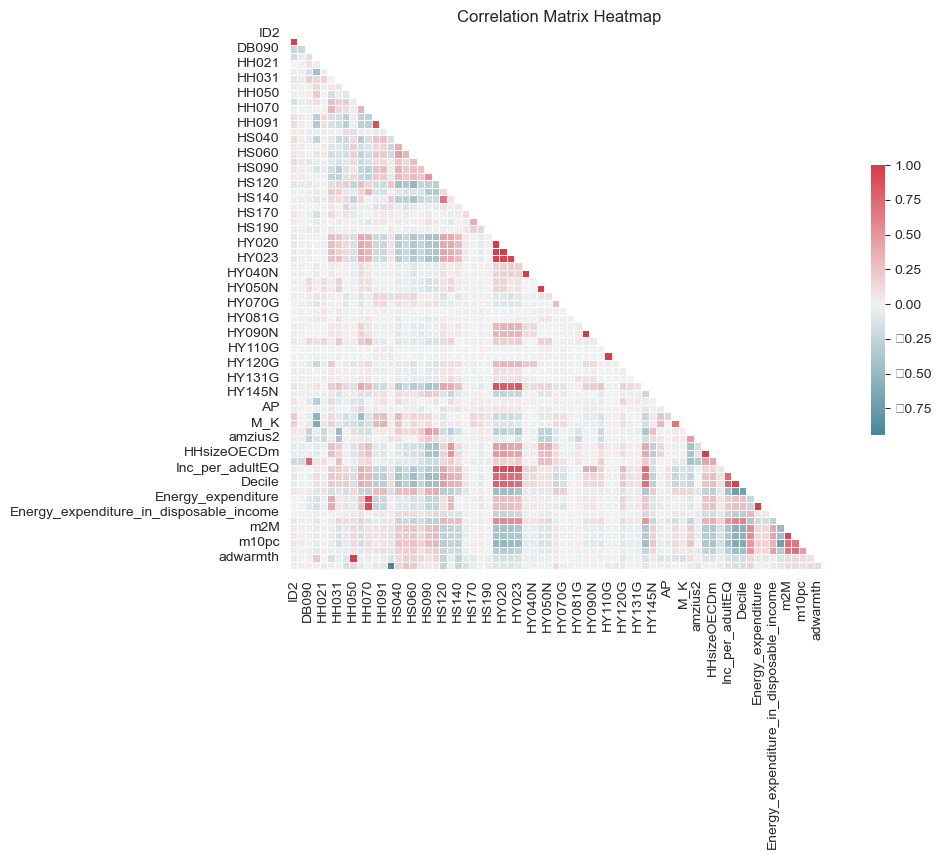

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams


#df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned[df_cleaned['HH061'].notna()]
df_cleaned = df_cleaned[df_cleaned['HH070'].notna()]
# Print the number of rows left in the cleaned DataFrame
print(f'Number of Rows Left: {df_cleaned.shape[0]}')

# Assuming df_cleaned is your DataFrame
df_cleaned = df_cleaned.fillna(df_cleaned.mean())

df_cleaned.to_csv('df_cleaned1.csv', index=False)
# Print the number of rows left in the cleaned DataFrame
print(f'Number of Rows Left after removal: {df_cleaned.shape[0]}')

# Set a font that includes the minus sign (−)
rcParams['font.family'] = 'DejaVu Sans'


# Print the correlation matrix with heatmap
correlation_matrix = df_cleaned.corr()

# Create a mask for the upper triangle
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(11, 7))
sns.set_style("white")

# Create a diverging color palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, square=True, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": 0.5})

plt.title("Correlation Matrix Heatmap")
plt.show()


In [5]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def process_target_column(df_cleaned, target_column):
    # Extract features (X) and target variable (y)
    X = df_cleaned.drop(target_column, axis=1)
    y = df_cleaned[target_column]

    # Split the data into train and test sets (adjust test_size as needed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check if it's a classification or regression task
    is_classification = len(y_train.value_counts()) <= 2

    # Create the appropriate model
    if is_classification:
        model = RandomForestClassifier(n_estimators=100, random_state=0)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=0)

    # Fit the model to the training set
    model.fit(X_train, y_train)

    # View the feature scores
    feature_scores = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

    # Calculate the correlation matrix
    corr_matrix = df_cleaned.corr()
    target_correlation = corr_matrix[target_column].abs().sort_values(ascending=False)
    target_correlation = target_correlation.iloc[1:]

    # Initialize the SelectKBest with f_regression
    selector = SelectKBest(score_func=f_regression, k='all')

    # Fit the selector on the data
    fit = selector.fit(X, y)

    # Create a Series with feature scores and sort them in descending order
    scores = pd.Series(fit.scores_, index=X.columns).sort_values(ascending=False)

    # Convert scores to NumPy arrays for reshaping
    feature_scores_array = feature_scores.to_numpy().reshape(-1, 1)
    target_correlation_array = target_correlation.to_numpy().reshape(-1, 1)
    scores_array = scores.to_numpy().reshape(-1, 1)

    # Use MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize scores for each algorithm
    normalized_scores_algo1 = scaler.fit_transform(feature_scores_array)
    normalized_scores_algo2 = scaler.fit_transform(target_correlation_array)
    normalized_scores_algo3 = scaler.fit_transform(scores_array)

    # Combine the normalized scores
    combined_scores = (normalized_scores_algo1 + normalized_scores_algo2 + normalized_scores_algo3) / 3

    # Get column names
    column_names = feature_scores.index

    # Create a dictionary to store relevant information
    result_dict = {
        'target_column': target_column,
        'X_train_shape': X_train.shape,
        'X_test_shape': X_test.shape,
        'y_train_shape': y_train.shape,
        'y_test_shape': y_test.shape,
        'feature_scores': feature_scores,
        'target_correlation': target_correlation,
        'scores': scores,
        'combined_scores': combined_scores,
        'column_names': column_names,
        'is_classification': is_classification
    }

    return result_dict

# Create a dictionary to store results for different target columns
all_results = {}

# Process 'HH061'
result_HH061 = process_target_column(df_cleaned, 'HH061')
all_results['HH061'] = result_HH061

# Process 'HH070'
result_HH070 = process_target_column(df_cleaned, 'HH070')
all_results['HH070'] = result_HH070

# Access the results as needed, for example:
for target_column, result in all_results.items():
    print(f"Combined Scores for {target_column}:")
    for name, score in zip(result['column_names'], result['combined_scores']):
        print(f"{name}: {score[0]:.4f}")

    print("\n" + "="*50 + "\n")  # Add a separator for better readability

# Save the variable 'all_results' for later use in the next block of code
joblib.dump(all_results, 'feature_importance_results.joblib')


Combined Scores for HH061:
SL: 1.0000
HH030: 0.7091
HY140G: 0.5972
AP: 0.5679
HH031: 0.5578
HH070: 0.5154
HS130: 0.5016
HY010: 0.4813
HY022: 0.4654
amzius1: 0.4138
Inc_per_adultEQ: 0.4000
DB090: 0.3416
amzius2: 0.3252
HY120G: 0.3207
Energy_expenditure_in_disposable_income: 0.3163
persons: 0.3078
Energy_exenditure_without_compensations: 0.3061
HS120: 0.2974
HY023: 0.2828
Energy_expenditure: 0.2719
ID2: 0.2705
HH091: 0.2573
HH010: 0.2292
HY020: 0.2287
HB030: 0.2119
HY100G: 0.1982
HY170G: 0.1902
HY145N: 0.1886
HY090N: 0.1864
HY090G: 0.1834
HD080: 0.1812
HS140: 0.1687
HHsizeOECDm: 0.1618
HS040: 0.1594
HS060: 0.1585
HH040: 0.1563
HY040G: 0.1398
HY040N: 0.1358
HH081: 0.1287
HY050G: 0.1219
HY130G: 0.1167
HY050N: 0.1130
HY131G: 0.1124
Decile: 0.1080
HS180: 0.1049
HH050: 0.0976
HH021: 0.0917
Hhsize: 0.0915
HY060G: 0.0870
HY080G: 0.0815
HS110: 0.0796
HS170: 0.0747
HS090: 0.0625
adwarmth: 0.0469
M_K: 0.0450
Quintile: 0.0386
HS160: 0.0377
HS021: 0.0357
HS050: 0.0330
HY081G: 0.0289
m2M: 0.0287
m1M:

['feature_importance_results.joblib']

In [6]:
import pandas as pd
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Assume df_cleaned and all_results are defined

# Remove columns with less than 0.1 combined score for both target columns
threshold = 0.03

target_columns = ['HH061', 'HH070']
rf_models = {}
column_orders = {}  # Dictionary to store column orders for each target column
scalers = {}  # Dictionary to store MinMaxScaler for each target column

for target_column in target_columns:
    # Create a copy of the DataFrame for each target
    df_target = df_cleaned.copy()

    least_important_columns = all_results[target_column]['column_names'][all_results[target_column]['combined_scores'].flatten() < threshold]
    df_target.drop(columns=least_important_columns, inplace=True)

    # Create a MinMaxScaler
    scaler = MinMaxScaler()

    # Extract features (X) and target variable (y)
    X = df_target.drop(columns=target_columns, axis=1)
    y = df_target[target_column]

    # Save the order of columns in X
    column_orders[target_column] = X.columns.tolist()

    # Normalize features
    X_normalized = scaler.fit_transform(X)

    # Save the MinMaxScaler
    scalers[target_column] = scaler

    # Split the normalized data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=1337)

    # Create the Gradient Boosting regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)

    # Fit the model to the training set
    rf_regressor.fit(X_train, y_train)

    # Save the trained model
    model_filename = f'rf_model_{target_column}.joblib'
    joblib.dump(rf_regressor, model_filename)
    rf_models[target_column] = model_filename

# Save the column orders and scalers
joblib.dump(column_orders, 'column_orders_rf.joblib')
joblib.dump(scalers, 'scalers_rf.joblib')

['scalers_rf.joblib']

In [7]:
import pandas as pd
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Assume df_cleaned and all_results are defined

# Remove columns with less than 0.1 combined score for both target columns
threshold = 0.03

target_columns = ['HH061', 'HH070']
gb_models = {}
column_orders = {}  # Dictionary to store column orders for each target column
scalers = {}  # Dictionary to store MinMaxScaler for each target column

for target_column in target_columns:
    # Create a copy of the DataFrame for each target
    df_target = df_cleaned.copy()

    

    least_important_columns = all_results[target_column]['column_names'][all_results[target_column]['combined_scores'].flatten() < threshold]
    df_target.drop(columns=least_important_columns, inplace=True)

    # Create a MinMaxScaler
    scaler = MinMaxScaler()

    # Extract features (X) and target variable (y)
    X = df_target.drop(columns=target_columns, axis=1)
    y = df_target[target_column]

    # Save the order of columns in X
    column_orders[target_column] = X.columns.tolist()

    # Normalize features
    X_normalized = scaler.fit_transform(X)

    # Save the MinMaxScaler
    scalers[target_column] = scaler

    # Split the normalized data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=1337)

    # Create the Gradient Boosting regressor
    gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=0)

    # Fit the model to the training set
    gb_regressor.fit(X_train, y_train)

    # Save the trained model
    model_filename = f'gb_model_{target_column}.joblib'
    joblib.dump(gb_regressor, model_filename)
    gb_models[target_column] = model_filename

# Save the column orders and scalers
joblib.dump(column_orders, 'column_orders_gb.joblib')
joblib.dump(scalers, 'scalers_gb.joblib')

['scalers_gb.joblib']